In [1]:
from scipy.interpolate import interp1d
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.5)
sns.set_palette(sns.color_palette("Paired"))
import numpy as np

from pyCode.component import Component
from pyCode.boltzSolver import BoltzSolution
from pyCode.AuxDecays import DecayList, Decay
from pyCode.EqFunctions import *


INFO:pyCode.AuxFuncs:Loading aux functions. Ignoring BSM corrections to g* and g*_S


In [2]:
#     lamb = 2.6e-7
lamb = 0.17
decays = DecayList()
decayToDM = Decay(instate='Mediator',fstates=['DM','radiation'],br=1.)
decays.addDecay(decayToDM)
decays.Xfraction = 0.1
decays.width = 2.49e-15*(lamb/4.3e-7)**2


#Get the model parameters (or define them here):
TRH = 1e4
TF = 1e-2

def nEQbottom(T):
    Zeta3 = 1.20206
    return 3*2*(3./4.)*Zeta3*T**3/np.pi**2

def nEQgluon(T):
    Zeta3 = 1.20206
    return 8*2*Zeta3*T**3/np.pi**2

#Annihilation rate for mediator
data = np.genfromtxt('./width_and_medxs.dat',skip_header=5)
dataR = np.genfromtxt('./sigmav_conversion_bchi-sbotg_500_510_1.dat',skip_header=6,usecols=(0,4))
conv = 0.8579e17

sLog = lambda x: interp1d(data[:,0],np.log(data[:,1]*conv),
                    fill_value='extrapolate',bounds_error=False)(x)
cRateLog = lambda x: interp1d(dataR[:,0],np.log(dataR[:,1]*conv*(lamb)**2),
                    fill_value='extrapolate',bounds_error=False)(x)

#Conversion rates for DM and mediator: 
dofDM = -2 #Number of DM degrees of freedom (Majorana fermion)
dofMed = 6 #Number of Mediator degrees of freedom (complex colored scalar)

@np.vectorize
def sigmaVJan(T):
    x = 500./T
    if x > data[:,0].max():
        return 0.
    sF = sLog(x)
    return np.exp(sF)

@np.vectorize
def cRateDMJan(T):
    x = 500./T
    if x > dataR[:,0].max():
        return 0.
    sF = cRateLog(x)
    return 2*nEQbottom(T)*np.exp(sF)

@np.vectorize
def cRateMedJan(T):
    x = 510./T
    if x > dataR[:,0].max():
        return 0.
    sF = cRateLog(x)
    return 2*nEQgluon(T)*np.exp(sF)*abs(dofMed/dofDM)*np.exp((510.-500.)/T)

In [3]:
#Define the components to be evolved and their properties:    
dm = Component(label='DM',Type='thermal',dof=dofDM,
               mass=500.
                ,coSigmav=lambda T,other: 1e-10*sigmaVJan(T)
                ,sigmav=lambda T: 1e-10*sigmaVJan(T)
                ,convertionRate=lambda T,other: cRateDMJan(T)
               )
mediator = Component(label='Mediator',Type='thermal',dof=dofMed,
               mass=510.,decays=decays,
               sigmav=sigmaVJan
                ,convertionRate=lambda T,other: cRateMedJan(T)
               )
compList = [dm,mediator]

In [4]:
skiplines = 10
d = np.genfromtxt('test.dat',names=True,skip_header=skiplines)
nlist = np.array([d['n_DM'],d['n_Mediator']])
rholist = np.array([d['rho_DM'],d['rho49.999999999999090505298,_Mediator']])
Slist = d['S']
Tlist = d['T']
xlist = d['x']
R = d['R']
nComp = 2

In [5]:
isActive = np.array([True,True])
labelsDict = dict([[comp.label,i] for i,comp in enumerate(compList)])

In [6]:
eqTerms = {'dNi/dx' : [], 'n' : [], r'$\rho$' : [], 
           'Annihilation' : [],
          'Co-Annihilation' : [],
          'Annihilation Conversion' : [],
          'Scattering Conversion' : [],
          'Decay' : [],
          'Inverse Decay' : [],
          'Injection' : [],
          'Expansion': []}

xdict = {'m/T' : []}

for iT,T in enumerate(Tlist):
#     if 500./T < 15. or 500./T > 100.:
#         continue
        
    n = nlist[:,iT]
    n0 = nlist[:,0]
    rho = rholist[:,iT]
    S = Slist[iT]
    S0 = Slist[0]
    x = xlist[iT]
    #Ni = log(n_i/s_0)
    Ni = np.log(n/n0)
    #R = rho_i/n_i
    Ri = rho/n
    #NS = log(S/S_0)
    NS = np.log(S/S0)

    #Compute equilibrium densities:
    neq = [comp.nEQ(T) for comp in compList]

    #Compute ratio of equilibrium densities
    #(helps with numerical instabilities)
    #rNeq[i,j] = neq[i]/neq[j]
    rNeq = np.array([[compi.rNeq(T,compj) for compj in compList] for compi in compList])

    #Dictionary with label:index mapping:
    labelsDict = dict([[comp.label,i] for i,comp in enumerate(compList)])

    #Compute Hubble factor:
    rhoTot = np.sum(rho,where=isActive,initial=0)
    rhoRad = (pi**2/30)*gSTAR(T)*T**4  # thermal bath's energy density    
    rho = rhoRad+rhoTot
    MP = 1.22e19
    H = sqrt(8*pi*rho/3)/MP

    #Effective equilibrium densities and BRs:
    #NXth[i] = N^{th}_i:
    NXth = np.array([compi.getNXTh(T,n,rNeq,labelsDict) for compi in compList])
    #NXYth[i,j] = N^{th}_{ij}:
    NXYth = np.array([[compi.getNXYTh(T,n,rNeq,labelsDict,compj) if not compj is compi and compj.active 
                       else 0. for compj in compList] for compi in compList])
    #NXY2th[i,j] = N2^{th}_{ij}:
    NXY2th = np.array([[compi.getNXY2Th(T,n,rNeq,labelsDict,compj) if not compj is compi and compj.active 
                        else 0. for compj in compList] for compi in compList])

    #Effective branching ratio (Beff[i,j] = B^{eff}_{ij}:
    Beff = np.array([[compi.getTotalBRTo(T,compj) if not compj is compi and compj.active 
                      else 0. for compj in compList] for compi in compList])

    widths = np.array([comp.width(T) for comp in compList])
    masses = np.array([comp.mass(T) for comp in compList])
    BRX = np.array([comp.getBRX(T) for comp in compList])
    sigmaV = np.array([comp.getSIGV(T) for comp in compList])

    # Derivative for entropy:
    dNS = np.sum(isActive*BRX*widths*masses*(n-NXth))*exp(3.*x - NS)/(H*T*S0)

    #Derivatives for the Ni=log(ni/s0) variables:
    dN = np.zeros(nComp)
    #Expansion term:
    RHS = -3*n
    eqTerms['Expansion'].append(-3*n)
    #Decay term:
    RHS -= widths*masses*n/(H*Ri)
    eqTerms['Decay'].append(-widths*masses*n/(H*Ri))
    #Inverse decay term:
    RHS += widths*masses*NXth/(H*Ri) #NXth should be finite if i -> j +..
    eqTerms['Inverse Decay'].append(isActive*widths*masses*NXth/(H*Ri))
    #Annihilation term:            
    RHS += isActive*sigmaV*(neq - n)*(neq + n)/H
    eqTerms['Annihilation'].append(isActive*sigmaV*(neq - n)*(neq + n)/H)
    # i + j <-> SM + SM:
    sigVij = [[compi.getCOSIGV(T,compj) if not compj is compi and compj.active else 0. 
                   for compj in compList] for compi in compList]
    RHS += np.einsum('ij,ij->i',sigVij,np.outer(neq,neq)-np.outer(n,n))/H
    eqTerms['Co-Annihilation'].append(np.einsum('ij,ij->i',sigVij,np.outer(neq,neq)-np.outer(n,n))/H)
    # i+i <-> j+j (sigVjj*rNeq[i,j]**2 should be finite)
    sigVjj = [[compi.getSIGVBSM(T,compj) if not compj is compi else 0.
               for compj in compList] for compi in compList]
    RHS += (np.einsum('ij,j,ij->i',rNeq**2,n**2,sigVjj)-n**2*np.einsum('ij->i',sigVjj))/H
    eqTerms['Annihilation Conversion'].append((np.einsum('ij,j,ij->i',rNeq**2,n**2,sigVjj)-n**2*np.einsum('ij->i',sigVjj))/H)
    # i+SM <-> j+SM (cRate*rNeq[i,j] should be finite)
    cRate = [[compi.getConvertionRate(T,compj) if not compj is compi else 0.
              for compj in compList] for compi in compList]
    RHS += (np.einsum('ij,j,ij->i',rNeq,n,cRate)-n*np.einsum('ij->i',cRate))/H
    eqTerms['Scattering Conversion'].append(isActive*(np.einsum('ij,j,ij->i',rNeq,n,cRate)-n*np.einsum('ij->i',cRate))/H)
    # j <-> i +SM (#NXYth[j,i] should be finite if j -> i +...)
    RHS += (np.einsum('ji,j,j,j->i',Beff,masses/Ri,widths,n)-np.einsum('ji,j,j,ji->i',Beff,masses/Ri,widths,NXYth))/H
    eqTerms['Injection'].append((np.einsum('ji,j,j,j->i',Beff,masses/Ri,widths,n)-np.einsum('ji,j,j,ji->i',Beff,masses/Ri,widths,NXYth))/H)
    
#     np.divide(RHS,n,out=dN,where=isActive)
    dN = RHS
    
    xdict['m/T'].append(500./T)
    eqTerms['n'].append(n)
    eqTerms[r'$\rho$'].append(rho)
    eqTerms['dNi/dx'].append(dN/n)
    eqTerms['Expansion'][-1] = eqTerms['Expansion'][-1]/n
    eqTerms['Decay'][-1] = eqTerms['Decay'][-1]/n
    eqTerms['Inverse Decay'][-1] = eqTerms['Inverse Decay'][-1]/n
    eqTerms['Annihilation'][-1] = eqTerms['Annihilation'][-1]/n
    eqTerms['Co-Annihilation'][-1] = eqTerms['Co-Annihilation'][-1]/n
    eqTerms['Annihilation Conversion'][-1] = eqTerms['Annihilation Conversion'][-1]/n
    eqTerms['Scattering Conversion'][-1] = eqTerms['Scattering Conversion'][-1]/n
    eqTerms['Injection'][-1] = eqTerms['Injection'][-1]/n
    
    
    
#     break

In [7]:
for key in eqTerms:
    eqTerms[key] = np.array(eqTerms[key]).transpose()
for key in xdict:
    xdict[key] = np.array(xdict[key])

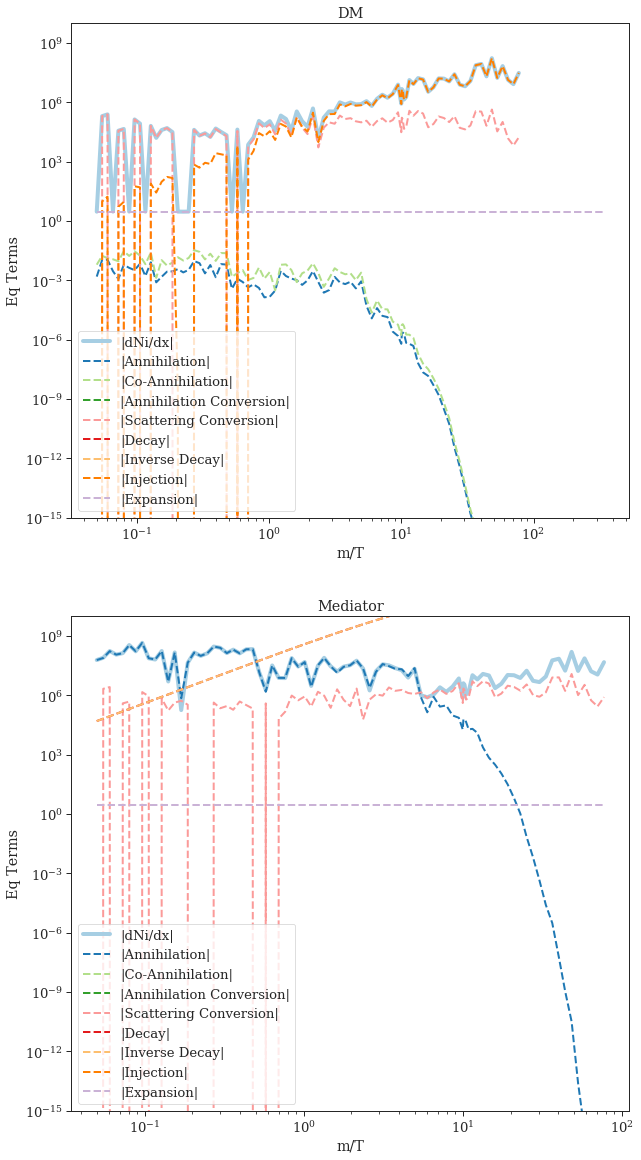

In [8]:
rowLabels = [comp.label for comp in compList]
curveLabels = list(eqTerms.keys())
nrows = len(rowLabels)

plt.figure(figsize=(10,20))

xvals = xdict['m/T']
xlabel = 'm/T'
isub = 0
yLog = True
xLog = True
for irow in range(nrows):
    isub += 1
    plt.subplot(nrows,1,isub)    
    for curve in curveLabels:
        if curve == 'n' or curve == r'$\rho$':continue
        if not np.count_nonzero(eqTerms[curve][irow,:]):
            continue
        if yLog:
            if 'dNi' in curve:
                plt.plot(xvals,np.abs(eqTerms[curve][irow,:]),linewidth=4,label='|'+curve+'|')
            else:
                plt.plot(xvals,np.abs(eqTerms[curve][irow,:]),linewidth=2,label='|'+curve+'|',linestyle='--')
        else:
            plt.plot(xvals,eqTerms[curve][irow,:],linewidth=2,label=curve)
    plt.title(rowLabels[isub-1])
    plt.xlabel(xlabel)
    plt.ylabel("Eq Terms")
    
    plt.ylim(1e-15,1e10)
#     plt.ylim(-1e2,3e3)
#     plt.xlim(10,30)
    if yLog:
        plt.yscale('log')
    if xLog:
        plt.xscale('log')
    plt.legend()
    
# plt.tight_layout()
plt.show()

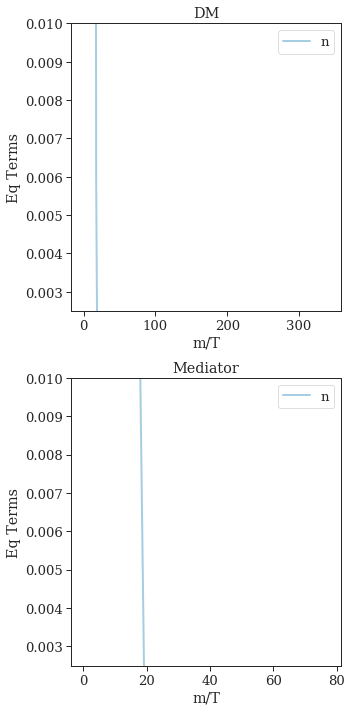

In [9]:
rowLabels = [comp.label for comp in compList]
curveLabels = list(eqTerms.keys())
nrows = len(rowLabels)

plt.figure(figsize=(5,10))

xvals = xdict['m/T']
xlabel = 'm/T'
isub = 0
yLog = False
xLog = False
for irow in range(nrows):
    isub += 1
    plt.subplot(nrows,1,isub)    
    for curve in curveLabels:
        if curve != 'n' and curve != r'$\rho$':continue
        if curve != 'n': continue
        if not np.count_nonzero(eqTerms[curve][irow,:]):
            continue
        if yLog:
            plt.plot(xvals,np.abs(eqTerms[curve][irow,:]),linewidth=2,label='|'+curve+'|')
        else:
            plt.plot(xvals,eqTerms[curve][irow,:],linewidth=2,label=curve)
    plt.title(rowLabels[isub-1])
    plt.xlabel(xlabel)
    plt.ylabel("Eq Terms")
    
    plt.ylim(0.0025,0.01)
    if yLog:
        plt.yscale('log')
    if xLog:
        plt.xscale('log')
    plt.legend()
    
plt.tight_layout()
plt.show()

IndexError: too many indices for array

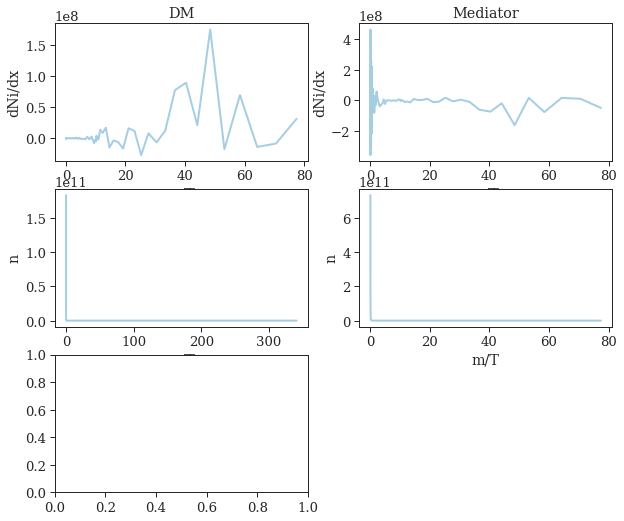

In [10]:
colLabels = [comp.label for comp in compList]
rowLabels = list(eqTerms.keys())
ncols = len(colLabels)
nrows = len(eqTerms)

plt.figure(figsize=(10,3*nrows))

xvals = xdict['m/T']
xlabel = 'm/T'
isub = 0
for irow in range(nrows):
    for icol in range(ncols):
        isub += 1
        plt.subplot(nrows,ncols,isub)
        plt.plot(xvals,eqTerms[rowLabels[irow]][icol,:],linewidth=2)
        plt.xlabel(xlabel)
        plt.ylabel(rowLabels[irow])
        if isub <= ncols:
            plt.title(colLabels[isub-1])
            

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(500./d['T'],d['n_Mediator'])
plt.plot(500./d['T'],d['n_DM'])
plt.yscale('log')
plt.xscale('log')
plt.show()